# U-Net for multi-class semantic segmentation

First load all the libraries


tensorboard --logdir=~/roaddetection/notebooks/networks/logs/

In [19]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.random.seed(42)

#from keras.layers import merge
from src.models.catdata import *
from src.models.catmodel import *
from src.models.catsegnet import *
from src.models.catloss import *

from src.data.utils import get_tile_prefix
from src.models.metrics_img import auc_roc, auc_pr, auc_pr_multiclass, dummy_metric
#import rasterio.plot as rioplot
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

from pathlib import Path
import os, shutil
import sys
%matplotlib inline

import pandas as pd

import math

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


from keras.callbacks import RemoteMonitor, TensorBoard, ReduceLROnPlateau, EarlyStopping, History
from keras import backend as keras

sys.path.append("/home/ubuntu/roaddetection/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create the train, validation and test data sets

To increase the U-Nets learning capacity, it is helpful to **first** train on high road-pixel density data.  This is achived by creating the corresponding image-sets according to the requirements.  

In a **second** training step all the images, e.g. also low and even zero road-pixel density data is considered.  

### Define the paths where the data is stored

In [20]:
original_dataset_dir = "../../data/train_raw"
raw_images_path = "../../data/raw/images"
dirs = []

base_dir = "../../data"

train_dir = os.path.join(base_dir, "train")
dirs.append(train_dir)
validation_dir = os.path.join(base_dir, "validate")
dirs.append(validation_dir)
test_dir = os.path.join(base_dir, "test")
dirs.append(test_dir)

print(train_dir)

../../data/train


### Create the directories if they don't exist

In [21]:
for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)

### Define a function which takes care of the assignement of image names to one of the three sets accoring to the desired pixel density of each class

In [22]:
r = 5

def selectData(tNoRoad = 0.95, tPRoad = 0, tURoad = 0, tEmpty = 0):
    df = pd.read_csv('../visualize_imagery/numOfPixPerClassPerTile_256.csv').drop(['Unnamed: 0'], axis = 1)

    any_RP = df[((df['relative_noRoad']) < tNoRoad) 
             & ((df['relative_pavedRoad']) > 0)
             & ((df['relative_unpavedRoad']) > 0)]
    
    unpaved_RP = df[((df['relative_noRoad']) < tNoRoad) 
                 & ((df['relative_pavedRoad']) == 0) 
                 & ((df['relative_unpavedRoad']) > tURoad)]
    
    paved_RP = df[((df['relative_noRoad']) < tNoRoad) 
                & ((df['relative_pavedRoad']) > tPRoad) 
                & ((df['relative_unpavedRoad']) == 0)]
    
    no_RP = df[(df['relative_noRoad'] == 1)].sample(frac=tEmpty, random_state=r)

    assert len(any_RP.merge(unpaved_RP)) == 0
    assert len(unpaved_RP.merge(paved_RP)) == 0
    assert len(paved_RP.merge(no_RP)) == 0
    assert len(no_RP.merge(any_RP)) == 0
    
    sdf = any_RP
    
    if tEmpty > 0:
        sdf = pd.concat([sdf, no_RP])
    if tPRoad > 0:
        sdf = pd.concat([sdf, paved_RP])
    if tURoad > 0:
        sdf = pd.concat([sdf, unpaved_RP])
    
    sdf = shuffle(sdf, random_state=r).sample(frac=.3, random_state=r).reset_index(drop=True)

    train_tmp, test = train_test_split(sdf, test_size=0.2, random_state=r)
    train, valid = train_test_split(train_tmp, test_size=0.2, random_state=r)
    return train, valid, test   

### Create the dataframes assigning the image names to the corresponding classes

In [23]:
train, valid, test = selectData()#tURoad = 0.06)

In [24]:
print("Train set")
print(train.region.value_counts())
print("")
print("Validation set")
print(valid.region.value_counts())
print("")
print("Test set")
print(test.region.value_counts())

Train set
Harz      169
Borneo     10
Name: region, dtype: int64

Validation set
Harz      42
Borneo     3
Name: region, dtype: int64

Test set
Harz      55
Borneo     1
Name: region, dtype: int64


### Define the function which copies the data according to the three dataframes

In [25]:
def should_make_tiles_from(r_analytic_name):
    is_analytic_tif = r_analytic_name.endswith(
        ('AnalyticMS.tif', 'AnalyticMS_SR.tif', 'AnalyticMS.tiff', 'AnalyticMS_SR.tiff')
    )
    return is_analytic_tif 

def copy(fnames, src_dir):
    for name in fnames:
        for file_type in ["sat", "map", "sat_rgb"]:
            src = os.path.join(original_dataset_dir, file_type, name)
            dest = os.path.join(src_dir, file_type, name)
            if(os.path.exists(src)):
                shutil.copy(src, dest)

def make_datasets(show_progress = False):
    file_prefixes = [ get_tile_prefix(r_analytic.name) 
                      for r_analytic in Path(raw_images_path).iterdir()  
                        if  should_make_tiles_from(r_analytic.name)
                    ]

    # copy files to train dir
    train_fnames = train.name.values
    copy(train_fnames, train_dir)
    print("Create train data.")

    # copy files to validation dir
    validation_fnames = valid.name.values
    copy(validation_fnames, validation_dir)
    print("Create validation data.")

    
    # copy files to test dir
    test_fnames = test.name.values
    copy(test_fnames, test_dir)
    print("Create test data.")

    # print overview
    if show_progress == True:
        for directory in dirs:
            for file_type in ["sat", "map", "sat_rgb"]:
                target = os.path.join(directory, file_type)
                print(target, ":", len(os.listdir(target)))

    print("Done.")

### Copy the data

In [26]:
#make_datasets()

# Create class weights accoriding to their train statistics

This is recommended as the classes are imbalanced (more no-road pixels than road pixels in each image)

In [27]:
labeldict = {
    0: train.numPixel_noRoad.mean(),
    1: train.numPixel_pavedRoad.mean(),
    2: train.numPixel_unpavedRoad.mean()
}

In [28]:
def create_class_weight(labels_dict,mu=0.25):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()
    weights = []
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
        weights.append(score if score > 1.0 else 1.0)
    return weights

# Define the data generator to flow the images from the directory while training

In [29]:
def data_generator(batch_size, data_gen_args, data_dir, imgdatagen_dir, target_size):
    return trainGenerator(
            batch_size,
            data_dir,
            'sat',
            'map',
            data_gen_args,
            save_to_dir = imgdatagen_dir,
            image_color_mode="rgba",
            target_size=target_size,
            flag_multi_class=True,
            num_class=3)

# Create the names of the models to save them on the hard drive

In [30]:
def model_name(model, th0, th1, batch_size, epochs):
    MODELDIR = '../../models/'
    
    mname = 'multicat_' + model + '_NL_th0-' + str(th0) \
            + '_th1-' + str(th1) + '_bs-' + str(batch_size) \
            + '_ep-' + str(epochs)
    
    versions = []
    for file in Path(MODELDIR).iterdir():
        if file.name.startswith((mname)):
            versions.append(int(file.name.rsplit(mname+'_r-')[1].split('.')[0]))
    latest = 1
    if len(versions) > 0:
        latest = np.max(versions) + 1
    model_name =  MODELDIR + mname + '_r-' + str(latest) + '.hdf5'
    pretrained = ''
    if(latest > 1):
        pretrained =  MODELDIR + mname + '_r-' + str(latest-1) + '.hdf5'
    return model_name, pretrained

# Modify the TensorBoard output such that training and validation metrics and losses are shown in one graph

In [42]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

# Define the training schedule

In [47]:
def go(model = 'unet', th0 = 0.01, th1 = 0.08, target_size = (256, 256), batch_size = 3, epochs = 5, data_aug = True, pretrained = False):
    
    valid_gen_args = dict(data_format="channels_last")
    
    if (data_aug == True):
        train_gen_args = dict(
            data_format="channels_last",
            horizontal_flip=True,
            vertical_flip=True
        )
    else:
        train_gen_args = valid_gen_args
    
    trained_model_fn, pretrained_model_fn = model_name(model, th0, th1, batch_size, epochs)
         
    steps_per_epoch  = len(train) // batch_size
    validation_steps = len(valid) // batch_size    
    
    optimizer    = Adam(lr=1e-3)
    loss_weights = None
    metrics      = ['accuracy', auc_pr_multiclass]
    
    imgdatagen_dir = None    
        
    train_gen      = data_generator(batch_size, train_gen_args, train_dir, imgdatagen_dir, target_size)    
    validation_gen = data_generator(batch_size, valid_gen_args, validation_dir, imgdatagen_dir,target_size)    
    
    width, height = target_size
    if model == 'unet':
        model = unet((width, height, 4), 3)
    if model == 'segnet':
        model = segnet((width, height, 4), 3)
        
    model.compile(optimizer=optimizer,
                  loss=noisy_loss(th0, th1),
                  loss_weights=loss_weights,
                  metrics=metrics)
    #model.summary()
    
    if (pretrained == True):
        if (len(pretrained_model_fn) > 0):
            print('... loading the pretrained model', pretrained_model_fn)
            model.load_weights(pretrained_model_fn)
        else:
            print('load default model')
            #model.load_weights('../../models/multicat_unet_NL_th0-0.08_th1-0.08_bs-3_ep-10_r-2.hdf5')
            model.load_weights('../../models/multicat_unet_NL_th0-0.01_th1-0.08_bs-3_ep-15_r-1.hdf5')#multicat_unet_NL_th0-0.08_th1-0.04_bs-3_ep-10_r-1.hdf5')#../../models/multicat_unet_NL_th0-0.01_th1-0.08_bs-3_ep-5_r-6.hdf5')
        
    model_checkpoint = ModelCheckpoint(trained_model_fn, monitor='loss',verbose=1, save_best_only=True)
    leaning_rate     = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    early_stop       = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None)
    hist             = History()
    tesorboard = TrainValTensorBoard(log_dir='./logs', batch_size=batch_size, 
                             write_graph=True, 
                             write_grads=True, 
                             write_images=True)

    class_weights = create_class_weight(labeldict)

    history = model.fit_generator(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=[model_checkpoint, leaning_rate, early_stop, hist, tesorboard],
        validation_data=validation_gen,
        validation_steps=validation_steps
    )

    return history, model

In [48]:
def plot_history(history):
    plt.plot(history["acc"], label="acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()#
    plt.plot(history["auc_pr_multiclass"], label="auc_pr_multiclass")
    plt.plot(history["val_auc_pr_multiclass"], label="val_auc_pr_multiclass")
    plt.legend()
    plt.show()
    plt.close()

In [49]:
def prediction(model):
    testGene = testGenerator("../../data/test/sat",target_size=(256, 256),as_gray=False)
    n = 0
    for img, name in testGene:
        results = model.predict(img, batch_size=1)
        saveResult("../../data/test/predict", results, name, True, 3)
        n += 1
        if(n>300):
            break

# Train the model and create the prediction afterwards

/home/ubuntu/roaddetection/src/models/catmodel.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (1, 1), activation="relu", padding="same")`
  conv10 = layers.Conv2D(nClasses, 1, 1, activation='relu',border_mode='same')(conv9)
/home/ubuntu/roaddetection/src/models/catmodel.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  model = Model(input=inputs, output=conv10)


... loading the pretrained model ../../models/multicat_unet_NL_th0-0.01_th1-0.01_bs-3_ep-50_r-1.hdf5
Epoch 1/50
Found 45 images belonging to 1 classes.
Found 179 images belonging to 1 classes.
Found 179 images belonging to 1 classes.
Found 45 images belonging to 1 classes.
59/59 [==============================] - 16s 276ms/step - loss: 0.1538 - acc: 0.8933 - auc_pr_multiclass: 0.0682 - val_loss: 0.1147 - val_acc: 0.9057 - val_auc_pr_multiclass: 0.0735

Epoch 00001: loss improved from inf to 0.15375, saving model to ../../models/multicat_unet_NL_th0-0.01_th1-0.01_bs-3_ep-50_r-2.hdf5
Epoch 2/50
59/59 [==============================] - 14s 240ms/step - loss: 0.1143 - acc: 0.9068 - auc_pr_multiclass: 0.0849 - val_loss: 0.1190 - val_acc: 0.9057 - val_auc_pr_multiclass: 0.0987

Epoch 00002: loss improved from 0.15375 to 0.11445, saving model to ../../models/multicat_unet_NL_th0-0.01_th1-0.01_bs-3_ep-50_r-2.hdf5
Epoch 3/50
59/59 [==============================] - 14s 240ms/step - loss: 0.1098

59/59 [==============================] - 14s 239ms/step - loss: 0.0816 - acc: 0.9233 - auc_pr_multiclass: 0.3477 - val_loss: 0.0839 - val_acc: 0.9172 - val_auc_pr_multiclass: 0.3488

Epoch 00028: loss did not improve from 0.07971
Epoch 29/50
59/59 [==============================] - 14s 238ms/step - loss: 0.0807 - acc: 0.9241 - auc_pr_multiclass: 0.3508 - val_loss: 0.0801 - val_acc: 0.9209 - val_auc_pr_multiclass: 0.3518

Epoch 00029: loss did not improve from 0.07971
Epoch 30/50
59/59 [==============================] - 14s 238ms/step - loss: 0.0770 - acc: 0.9255 - auc_pr_multiclass: 0.3548 - val_loss: 0.0760 - val_acc: 0.9275 - val_auc_pr_multiclass: 0.3579

Epoch 00030: loss improved from 0.07971 to 0.07674, saving model to ../../models/multicat_unet_NL_th0-0.01_th1-0.01_bs-3_ep-50_r-2.hdf5
Epoch 31/50
59/59 [==============================] - 14s 239ms/step - loss: 0.0784 - acc: 0.9255 - auc_pr_multiclass: 0.3605 - val_loss: 0.0753 - val_acc: 0.9274 - val_auc_pr_multiclass: 0.3634

Ep

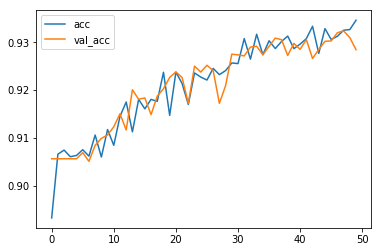

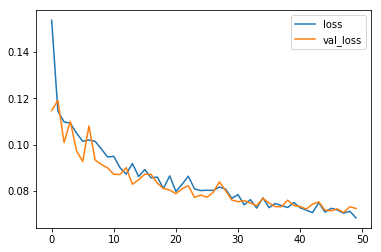

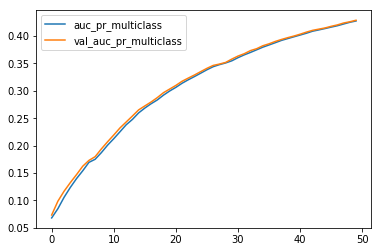

/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20180419_074326_0c43_3B_0244.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


... loading the pretrained model ../../models/multicat_unet_NL_th0-0.01_th1-0.01_bs-3_ep-50_r-2.hdf5
Epoch 1/50
Found 45 images belonging to 1 classes.
Found 179 images belonging to 1 classes.
Found 45 images belonging to 1 classes.
Found 179 images belonging to 1 classes.
59/59 [==============================] - 17s 296ms/step - loss: 0.0874 - acc: 0.9187 - auc_pr_multiclass: 0.2905 - val_loss: 0.0763 - val_acc: 0.9262 - val_auc_pr_multiclass: 0.4135

Epoch 00001: loss improved from inf to 0.08739, saving model to ../../models/multicat_unet_NL_th0-0.01_th1-0.01_bs-3_ep-50_r-3.hdf5
Epoch 2/50
59/59 [==============================] - 14s 245ms/step - loss: 0.0743 - acc: 0.9286 - auc_pr_multiclass: 0.4417 - val_loss: 0.0759 - val_acc: 0.9273 - val_auc_pr_multiclass: 0.4634

Epoch 00002: loss improved from 0.08739 to 0.07451, saving model to ../../models/multicat_unet_NL_th0-0.01_th1-0.01_bs-3_ep-50_r-3.hdf5
Epoch 3/50
59/59 [==============================] - 15s 248ms/step - loss: 0.0731

59/59 [==============================] - 14s 237ms/step - loss: 0.0563 - acc: 0.9435 - auc_pr_multiclass: 0.5613 - val_loss: 0.0689 - val_acc: 0.9360 - val_auc_pr_multiclass: 0.5635

Epoch 00030: loss improved from 0.05776 to 0.05606, saving model to ../../models/multicat_unet_NL_th0-0.01_th1-0.01_bs-3_ep-50_r-3.hdf5
Epoch 31/50
59/59 [==============================] - 14s 239ms/step - loss: 0.0596 - acc: 0.9404 - auc_pr_multiclass: 0.5650 - val_loss: 0.0688 - val_acc: 0.9330 - val_auc_pr_multiclass: 0.5666

Epoch 00031: loss did not improve from 0.05606
Epoch 32/50
59/59 [==============================] - 14s 238ms/step - loss: 0.0554 - acc: 0.9449 - auc_pr_multiclass: 0.5679 - val_loss: 0.0676 - val_acc: 0.9339 - val_auc_pr_multiclass: 0.5694

Epoch 00032: loss improved from 0.05606 to 0.05535, saving model to ../../models/multicat_unet_NL_th0-0.01_th1-0.01_bs-3_ep-50_r-3.hdf5
Epoch 33/50
30/59 [==============>...............] - ETA: 6s - loss: 0.0558 - acc: 0.9433 - auc_pr_multiclas

In [ ]:
glob_history = {}
for t0 in [0.01]:
    for t1 in [0.01]:
        for i in range(3):
            history, model = go(batch_size = 3, epochs = 50, pretrained = True, th0=t0, th1=t1)
            glob_history.update(history.history)
            plot_history(glob_history)
            prediction(model)
            del history
            del model
            keras.clear_session()